# Testing neural networks on NGSIM dataset!

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
import torchvision.models as models
from torchvision.models.resnet import resnet50
import torch.nn.functional as F
from tqdm import tqdm
import os
import random
import pandas as pd
import pickle
import MLP_model
np.random.seed(228)
random.seed(228)
torch.manual_seed(228)
torch.random.manual_seed(228)


In [2]:
filename = "Next_Generation_Simulation__NGSIM__Vehicle_Trajectories_and_Supporting_Data.csv"
NGSIM = pd.read_csv(filename)

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3437: DtypeWarning: Columns (13,22) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
def string2float(my_string):
    return float(my_string.replace(',',''))
NGSIM["Local_Y"] = NGSIM["Local_Y"].apply(string2float)

# Dataset info:
11,850,526 datapoints 
<br>
<b>Labels:</b> "Vehicle_ID" "Frame_ID" "Total_Frames" "Global_Time" "Local_X" "Local_Y" "Global_X"
                             "Global_Y" "v_length" "v_Width" "v_Class" "v_Vel" v_Acc Lane_ID O_Zone D_Zone Int_ID
                             Section_ID Direction Movement Preceding Following Space_Headway Time_Headway Location
<br>
<b>Locations:</b> "us-101" "i-80" "lankershim" "peachtree"

In [4]:
def get_id_list(data, location):
    '''
    Inputs:
        data: NGSIM subset data according to location (pandas DataFrame)
        location: location (string)
    '''
    filename = location + "_id_list"
    try:
        with open(filename, "rb") as fp:
            id_list = pickle.load(fp)
    except: 
        id_list = []
        for i in tqdm(range(data.shape[0])):
            if data.iloc[i].loc["Vehicle_ID"] not in id_list:
                id_list.append(data.iloc[i].loc["Vehicle_ID"])
        id_list.sort()
        with open(filename, "wb") as fp:
            pickle.dump(id_list, fp)
    
    return id_list

def filter_extra_IDs(vehicle_data):
    total_frame_tracker = []
    for i in range(vehicle_data.shape[0]):
        if vehicle_data.iloc[i].loc["Total_Frames"] not in total_frame_tracker:
            total_frame_tracker.append(vehicle_data.iloc[i].loc["Total_Frames"])
    most_frames = max(total_frame_tracker)
    vehicle_data = vehicle_data.loc[vehicle_data["Total_Frames"] == most_frames]
    return vehicle_data

def graph_lane_vs_frame(vehicle_data):
    Lane_ID = vehicle_data["Lane_ID"].to_numpy(dtype=np.float16)   
    fig, [ax1, ax2] = plt.subplots(2, 1, sharex=True)
    ax1.scatter(vehicle_data["Frame_ID"], Lane_ID)
    ax2.scatter(vehicle_data["Frame_ID"], vehicle_data["Local_X"])
    ax1.set_title("Lane ID")
    ax2.set_title("Local X")
    plt.xlabel("Frame ID")

def detect_switches(vehicle_data, delete_interval=1.5):
    Lane_ID = vehicle_data["Lane_ID"].to_numpy(dtype=int)
    boolean_switch = np.diff(Lane_ID)
    switch_index = np.where(boolean_switch != 0)
    switch_index = switch_index[0] + 1
    switch_frames = vehicle_data["Frame_ID"].iloc[switch_index].to_numpy()
    
    # sometimes the lane switch data is fuzzy. Deleting lane switches within <delete_interval> seconds
    if len(switch_frames) >= 2:
        delete_frames = int(delete_interval*10)
        frames_between_switches = np.diff(switch_frames)
        frames_too_close = frames_between_switches < delete_frames
        frames_too_close = np.append(False, frames_too_close)
        switch_frames = np.delete(switch_frames, frames_too_close)
    
    switch_frames = validate_switches(switch_frames, vehicle_data)
    
    # even if no lane change, we still want to sample
    if len(switch_frames)==0:
        lowest_frame = vehicle_data["Frame_ID"].iloc[0]+51
        highest_frame = vehicle_data["Frame_ID"].iloc[vehicle_data.shape[0]-1]-53
        switch_frames = [random.randint(lowest_frame, highest_frame)]
    return switch_frames

def validate_switches(switch_frames, vehicle_data):
    first_frame = vehicle_data["Frame_ID"].iloc[0]
    last_frame = vehicle_data["Frame_ID"].iloc[vehicle_data.shape[0]-1]

    bool_delete = np.zeros_like(switch_frames, dtype=bool)
    
    for index, value in enumerate(switch_frames):
        if abs(last_frame-value) <= 53 or abs(first_frame-value) <= 53:
            bool_delete[index] = True
    switch_frames = np.delete(switch_frames, bool_delete)
    return switch_frames
 
def extract_features(switch_frame, vehicle_data, time_interval=5):
    '''
    Inputs:
        switch_frame: singular lane switch frame
        vehicle_data: same as always
        time_interval: how much time in future and past we take into account. Default: 5s (50 frames before and after LC)
    Returns:
        first and second time derivatives using future values (for example: v_t calculated using x_t and x_(t+1)).
            Each is a 100-D array, with lane switch occuring at 51st index (50th if zero-indexing). Because of 
            downsampling when taking time difference, two extra timesteps must be considered in the frame_interval
    '''
    delta_t = 0.1
    num_frames = int(time_interval/delta_t*2)
    frame_interval = np.array([switch_frame-(time_interval/delta_t), switch_frame+(time_interval/delta_t)+2], dtype=int)
    # Extracting data within frame_interval
    interval_data = vehicle_data.loc[vehicle_data["Frame_ID"]>=frame_interval[0]]
    interval_data = interval_data.loc[vehicle_data["Frame_ID"]<=frame_interval[1]]
    x_pos = interval_data["Local_X"].to_numpy(dtype=np.float32)
    y_pos = interval_data["Local_Y"].to_numpy(dtype=np.float32)
    assert len(x_pos)==103
    assert len(y_pos)==103
    
    # Positional time derivatives
    delta_x = np.diff(x_pos)
    delta_y = np.diff(y_pos)
    v_x = delta_x/delta_t
    v_y = delta_y/delta_t
    delta_v_x = np.diff(v_x)
    
#     yaw = np.arctan(np.divide(v_x,v_y))
    yaw = np.arctan2(v_x, v_y)
    yaw_rate = np.diff(yaw)/delta_t
    
    yaw = yaw[:num_frames]
    yaw_rate = yaw_rate[:num_frames]
    lat_vel = v_x[:num_frames]
    lat_accel = delta_v_x/delta_t
    lat_accel = lat_accel[:num_frames]
    
    extracted_data = np.zeros((num_frames, 4))
    extracted_data[:,0] = yaw
    extracted_data[:,1] = yaw_rate
    extracted_data[:,2] = lat_vel
    extracted_data[:,3] = lat_accel
    
    return extracted_data

def detect_lane_change(frame, vehicle_data):
    '''
    Detects and returns hot one encoding for left lane switch [1 0 0], no change [0 1 0] or right lane switch [0 0 1]

    '''

    prev_lane = vehicle_data.loc[vehicle_data["Frame_ID"]==frame-1]["Lane_ID"].to_numpy(dtype=int)
    current_lane = vehicle_data.loc[vehicle_data["Frame_ID"]==frame]["Lane_ID"].to_numpy(dtype=int)
    
    if len(prev_lane)!=1 or len(current_lane)!=1:
        return False

    if current_lane == prev_lane:
        LS = np.array([0, 1, 0])
    elif current_lane < prev_lane:
        LS = np.array([1, 0, 0])
    elif current_lane > prev_lane:
        LS = np.array([0, 0, 1])
    return LS
        
    

In [5]:
class Extracted_dataset:
    def __init__(self, num_validation_data=300,num_training_data=80,num_timesteps=100):
        self.num_validation_data=num_validation_data
        self.num_training_data=num_training_data
        self.total_num_data = self.num_validation_data + self.num_training_data
        self.num_extracted_data = 4
        self.num_timesteps = num_timesteps
        
        self.left_turn_data = np.zeros((self.total_num_data, self.num_timesteps, self.num_extracted_data))
        self.right_turn_data = np.zeros((self.total_num_data, self.num_timesteps, self.num_extracted_data))
        self.lane_keep_data = np.zeros((self.total_num_data, self.num_timesteps, self.num_extracted_data))
        
        self.track_num_left = 0
        self.track_num_right = 0
        self.track_num_keep = 0
        
        self.hot_dict = {
            "Left": np.array([1, 0, 0]),
            "Keep": np.array([0, 1, 0]),
            "Right": np.array([0, 0, 1])
        }
        
    def add(self, X, y):
        if np.all(y==self.hot_dict["Keep"]):
            if self.track_num_keep < self.total_num_data:
                self.lane_keep_data[self.track_num_keep, :, :] = X
                self.track_num_keep += 1
        if np.all(y==self.hot_dict["Left"]):
            if self.track_num_left < self.total_num_data:
                self.left_turn_data[self.track_num_left, :, :] = X
                self.track_num_left += 1
        if np.all(y==self.hot_dict["Right"]):
            if self.track_num_right < self.total_num_data:
                self.right_turn_data[self.track_num_right, :, :] = X
                self.track_num_right += 1

In [6]:
# LOCATIONS = ["us-101", "i-80", "lankershim", "peachtree"]
LOCATIONS = ["us-101", "i-80"]
my_dataset = Extracted_dataset()
data_filename = "labeled_data"

try:
    with open(data_filename, "rb") as fp:
        data_with_labels = pickle.load(fp)
except:
    for location in LOCATIONS:
        data = NGSIM.loc[NGSIM["Location"] == location]
        id_list = get_id_list(data, location)

        for i in tqdm(id_list):
            vehicle_data = data.loc[data["Vehicle_ID"] == i].sort_values("Frame_ID")
            vehicle_data = filter_extra_IDs(vehicle_data)

            switch_frames = detect_switches(vehicle_data)

            for single_switch_frame in switch_frames:
                lane_change = detect_lane_change(single_switch_frame, vehicle_data)
                if lane_change is not False:
                    extracted_data = extract_features(single_switch_frame, vehicle_data)
                    my_dataset.add(extracted_data, lane_change)
                else:
                    continue
    left_data = np.copy(my_dataset.left_turn_data)
    keep_data = np.copy(my_dataset.lane_keep_data)
    right_data = np.copy(my_dataset.right_turn_data)

    complete_data = np.concatenate((left_data, keep_data, right_data), axis=0)

    complete_labels = np.zeros((1140,3))
    complete_labels[0:380, :] = [1, 0, 0]
    complete_labels[380:380*2, :] = [0, 1, 0]
    complete_labels[380*2:, :] = [0, 0, 1]

    randperm = np.random.permutation(1140)
    shuffled_data = complete_data[randperm, :]
    shuffled_labels = complete_labels[randperm, :]

    data_with_labels = [shuffled_data, shuffled_labels]
    data_filename = "labeled_data"
    with open(data_filename, "wb") as fp:
        pickle.dump(data_with_labels, fp)

print(data_with_labels[0].shape)
print(data_with_labels[1].shape)

(1140, 100, 4)
(1140, 3)


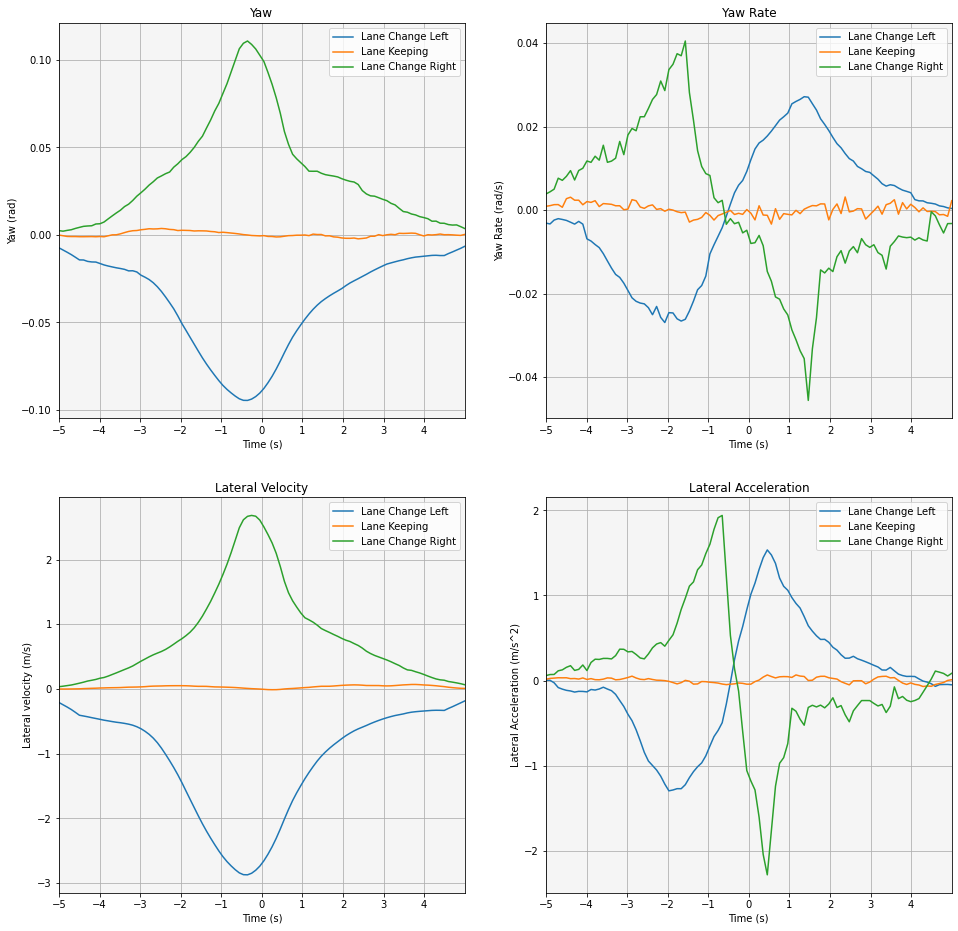

In [7]:
# Reverse engineer data for graphs:
data = data_with_labels[0]
labels = data_with_labels[1]
left_index = labels[:, 0].astype(bool)
keep_index = labels[:, 1].astype(bool)
right_index = labels[:, 2].astype(bool)

left_data = data[left_index, :]
keep_data = data[keep_index, :]
right_data = data[right_index, :]

left_avg = np.average(left_data, axis=0)
keep_avg = np.average(keep_data, axis=0)
right_avg = np.average(right_data, axis=0)
# Ax1 plotting 
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
fig.set_size_inches(16, 16)

def smooth(y, box_pts=11):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth
time_frame = np.linspace(-5,5,num=100)

ax1.plot(time_frame, smooth(left_avg[:, 0]))
ax1.plot(time_frame, smooth(keep_avg[:, 0]))
ax1.plot(time_frame, smooth(right_avg[:, 0]))
ax1.legend(["Lane Change Left", "Lane Keeping", "Lane Change Right"])
ax1.title.set_text("Yaw")
ax1.grid()
ax1.set_xlim([-5, 5])
ax1.set_xticks(range(-5,5))
ax1.set_xlabel("Time (s)")
ax1.set_ylabel("Yaw (rad)")
ax1.set_facecolor('whitesmoke')

ax2.plot(time_frame, smooth(left_avg[:, 1], 30))
ax2.plot(time_frame, smooth(keep_avg[:, 1], 30))
ax2.plot(time_frame, smooth(right_avg[:, 1], 30))
ax2.legend(["Lane Change Left", "Lane Keeping", "Lane Change Right"])
ax2.title.set_text("Yaw Rate")
ax2.grid()
ax2.set_xlim([-5, 5])
ax2.set_xticks(range(-5,5))
ax2.set_xlabel("Time (s)")
ax2.set_ylabel("Yaw Rate (rad/s)")
ax2.set_facecolor('whitesmoke')

ax3.plot(time_frame, smooth(left_avg[:, 2]))
ax3.plot(time_frame, smooth(keep_avg[:, 2]))
ax3.plot(time_frame, smooth(right_avg[:, 2]))
ax3.legend(["Lane Change Left", "Lane Keeping", "Lane Change Right"])
ax3.title.set_text("Lateral Velocity")
ax3.grid()
ax3.set_xlim([-5, 5])
ax3.set_xticks(range(-5,5))
ax3.set_xlabel("Time (s)")
ax3.set_ylabel("Lateral velocity (m/s)")
ax3.set_facecolor('whitesmoke')

ax4.plot(time_frame, smooth(left_avg[:, 3]))
ax4.plot(time_frame, smooth(keep_avg[:, 3]))
ax4.plot(time_frame, smooth(right_avg[:, 3]))
ax4.legend(["Lane Change Left", "Lane Keeping", "Lane Change Right"])
ax4.title.set_text("Lateral Acceleration")
ax4.grid()
ax4.set_xlim([-5, 5])
ax4.set_xticks(range(-5,5))
ax4.set_xlabel("Time (s)")
ax4.set_ylabel("Lateral Acceleration (m/s^2)")
ax4.set_facecolor('whitesmoke')

  0%|          | 0/10 [00:00<?, ?it/s]
loss: 1.0986003875732422 loss(avg ): 1.0986182391643524:   0%|          | 0/10 [00:00<?, ?it/s]

NN(
  (ourNN): Sequential(
    (Hidden_0): Linear(in_features=4, out_features=20, bias=True)
    (Sigmoid_0): Sigmoid()
    (Hidden_1): Linear(in_features=20, out_features=20, bias=True)
    (Sigmoid_1): Sigmoid()
    (Output_layer): Linear(in_features=20, out_features=3, bias=True)
    (Output_Softmax_activation): Softmax(dim=None)
  )
)


  0%|          | 0/10 [00:00<?, ?it/s].0986150607728122:   0%|          | 0/10 [00:00<?, ?it/s]
loss: 1.0984987020492554 loss(avg ): 1.0986150607728122:   0%|          | 0/10 [00:00<?, ?it/s]


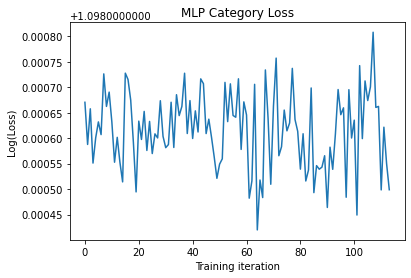

In [11]:
"""Training MLP to predict maneuver class
"""

data_filename = "labeled_data"
with open(data_filename, "rb") as fp:
    data_with_labels = pickle.load(fp)
    x_all_batches = data_with_labels[0]
    y_all_batches = data_with_labels[1]

batch_size = 1
num_epochs = 10
trained_model, loss= MLP_model.train_on_data(x_all_batches=x_all_batches,
                                             y_all_batches=y_all_batches,
                                             num_iterations=900,
                                             n_layers=2,
                                             size=20,
                                             batch_size = 10,
                                             num_epochs = num_epochs,
                                             device="cuda")
# def predict_maneuver_class():
plt.figure()
plt.plot(loss)
plt.title("MLP Category Loss")
plt.ylabel("Log(Loss)")
plt.xlabel("Training iteration")
plt.show()